In [ ]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime, timedelta
def get_lick_df(MouseObject, drop_last_trial=True):
    if "TX" in MouseObject.name:
        df = pd.DataFrame(MouseObject._timeline["Licks"].T, columns=["trial", "distance","alpha","is_rewarded","time", "flag"])
    else:
        df = pd.DataFrame(MouseObject._timeline["Licks"].T, columns=["trial", "distance","alpha","is_rewarded","time", "flag", "istest"])
    df["datetime"] = pd.to_datetime(
        df["time"].apply(
            lambda x: datetime.fromordinal(int(x))
            + timedelta(days=x % 1)
            - timedelta(days=366)
        )
    )
    df = df.assign(distance = df["distance"]*10)
    df = df.assign(date=df["datetime"].dt.date)
    df = df.assign(hour_min_sec=df["datetime"].dt.time)
    df = df.assign(seconds_in_session=(df["datetime"] - df["datetime"][0]).dt.total_seconds())
    if drop_last_trial:
        n_trials = df.trial.unique()[-2].astype(int)
        df = df.loc[df.trial != df.trial.max()]
    else:
        n_trials = df.trial.unique()[-1].astype(int)
    isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
    isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
    trial_type , _ = utils.get_trial_categories(isrewarded, isnew)
    for ix, ttype in enumerate(trial_type):
        df.loc[df.trial == ix+1, "trial_type"] = ttype
    df.drop(["time","datetime","is_rewarded","alpha"], axis=1, inplace=True)
    return df


def get_learning_history(sessions_df):

    def proportion_byblocks(MouseObject, lick_window=(150, 250), n_blocks=4):
        def count_trial(isrewarded, isnew):
            rew_n = (np.logical_not(isnew) * isrewarded).sum()
            nrew_n = (np.logical_not(isnew) * np.logical_not(isrewarded)).sum()
            rewtest_n = (isnew * isrewarded).sum()
            nrewtest_n = (isnew * np.logical_not(isrewarded)).sum()
            counts = {'rewarded': rew_n, 
                    'non rewarded': nrew_n, 
                    'rewarded test': rewtest_n, 
                    'non rewarded test': nrewtest_n}
            return counts

        df = get_lick_df(MouseObject, drop_last_trial=True)
        n_trials = int(df.trial.max())
        block_size = n_trials//n_blocks
        isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
        isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
        isrewarded_split = np.split(isrewarded[:n_blocks * block_size], n_blocks)
        isnew_split = np.split(isnew[:n_blocks * block_size], n_blocks)
        df = df.loc[df.flag != 1]
        prop_dict = {"rewarded": [], "non rewarded": [], "rewarded test": [], "non rewarded test": [], "trial_block": [],  "block_n": []}
        df = df.loc[(df.distance >= lick_window[0]) & (df.distance <= lick_window[1])]
        trials_splits = np.arange(1, n_trials, block_size)
        if len(trials_splits) < n_blocks+1:
            trials_splits = np.append(trials_splits, n_trials)
        for i_blk, (rew_block, new_block) in enumerate(zip(isrewarded_split, isnew_split)):
            counts = count_trial(rew_block, new_block)
            for ttype, trial_no in counts.items():
                if trial_no != 0:
                    subdf = df.query(f"trial_type == '{ttype}' & trial >= {trials_splits[i_blk]} & trial < {trials_splits[i_blk+1]}")
                    licks_in_trialtype = len(subdf.loc[:,'trial'].unique())
                    prop_dict[ttype].append(licks_in_trialtype / trial_no)
                else:
                    prop_dict[ttype].append(0)
            prop_dict["trial_block"].append((trials_splits[i_blk], trials_splits[i_blk+1]))
            prop_dict["block_n"].append(i_blk)
        df_counts = pd.DataFrame(prop_dict)
        return df_counts

    all_sessions_notTX = sessions_df.query("mname.str.startswith('TX') == False & more_than_4 == False")
    all_first_sessions = all_sessions_notTX.query("n_trials >= 100")
    all_first_sessions['datexp'] = pd.to_datetime(all_first_sessions['datexp'])
    df_byblocks_sessions = pd.DataFrame()
    for row in all_first_sessions.iterrows():
        name = str(row[1]['mname'])
        date = row[1]['datexp'].strftime("%Y_%m_%d")
        blk = str(row[1]['blk'])
        m = utils.load_mouse(name, date, blk, load_neurons=False, load_retinotopy=False)
        tmp_df = proportion_byblocks(m, lick_window=(150, 250), n_blocks=4)
        tmp_df['mname'] = row[1]['mname']
        tmp_df['datexp'] = row[1]['datexp']
        tmp_df['blk'] = row[1]['blk']
        tmp_df['cat_pair'] = row[1]['cat_pair']
        tmp_df['positive_category'] = row[1]['positive_category']
        tmp_df['negative_category'] = row[1]['negative_category']
        tmp_df['train_day'] = row[1]['train_day']
        tmp_df['Session'] = row[1]['Session']
        df_byblocks_sessions = pd.concat([df_byblocks_sessions, tmp_df], axis=0)
    df_byblocks_sessions['cat_pair_n'] = df_byblocks_sessions.apply(get_catpair_n, axis=1)
    df_byblocks_sessions = df_byblocks_sessions.assign(DI = df_byblocks_sessions['rewarded'] - df_byblocks_sessions['non rewarded'], 
                                                    GI = df_byblocks_sessions['rewarded test'] - df_byblocks_sessions['non rewarded test'])
    training_day = df_byblocks_sessions['train_day'].unique()
    i = 0
    overall_days = np.arange(20)
    for day in training_day:
        for block_n in range(4):
            df_byblocks_sessions.loc[(df_byblocks_sessions['train_day'] == day) & (df_byblocks_sessions['block_n'] == block_n), 'overall_block'] = overall_days[i]
            i += 1
    return df_byblocks_sessions

def licksraster(MouseObject, ax):
    import seaborn as sns
    """
    Plot the lick data.

    Parameters
    ----------
    MouseObject : Mouse object
        Mouse object containing the data
    first_lick : bool
        If True, plot the first lick distribution over trials.
    fsize : tuple
        Figure size.
    lick_counter_lim : tuple
        Limits for the lick counter.

    Returns
    -------
    fig : figure
        Figure of lick data.
    """
    opt_dict = {
        "rewarded": "tab:green",
        "non rewarded": "tab:red",
        "rewarded test": "tab:cyan",
        "non rewarded test": "tab:orange",
    }
    #pct_axis = fig.add_subplot(grid[-2:, 5:])
    lick = get_lick_df(MouseObject, drop_last_trial=True)
    n_trials = int(lick.trial.max())
    isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
    isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
    trial_type , counts = utils.get_trial_categories(isrewarded, isnew)
    for key, value in counts.items():
        lick.loc[np.where(lick["trial_type"] == key)[0], "Weight"] = value
    lick = lick[lick["flag"] != 1]
    #lick = lick.iloc[::2]
    category_number = len(np.unique(trial_type))
    if category_number == 4:
        categories = ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]
    elif category_number == 2:
        categories = ["rewarded", "non rewarded"]
        

    for category in categories:
        position = lick[lick["trial_type"] == category]["distance"]
        trial = lick[lick["trial_type"] == category]["trial"]
        if category in ["rewarded", "non rewarded"]:
            ax.scatter(
                position,
                trial,
                marker="o",
                label=category,
                alpha=0.5,
                c = opt_dict[category],
                s=5,
            )
        elif category == "rewarded test":
            ax.scatter(
                position,
                trial,
                marker="X",
                alpha=0.2,
                label=category,
                c = opt_dict[category],
                s=5,
            )
        else:
            ax.scatter(
                position,
                trial,
                marker="X",
                alpha=0.2,
                label=category,
                c = opt_dict[category],
                s=5,
            )

    ax.set_xlabel("lick position (cm)")
    ax.set_ylabel("trial")
    ax.set_xlim(0, lick["distance"].max() + 10)
    #init_text = lick["distance"].max() -30
    i = 0
    change_dict = {'rewarded': 'train A', 'non rewarded': 'train B', 'rewarded test': 'test A', 'non rewarded test': 'test B'}
    for category in categories:
        ax.text(310,320-i,change_dict[category],color=opt_dict[category], size=12)
        i+=27
    ax.set_ylim(0, n_trials+30)
    ax.set_xticks([0, 150, 250, 400])
    ax.fill_betweenx([0, n_trials+19], [150],[250], color='tab:green', alpha=0.2)
    ax.vlines(300,0, n_trials+19, color='k', linestyle='--', alpha = 0.3)
    #add text for reward region
    ax.text(145, n_trials+30, "reward \n region", color='tab:green', size=12)
    ax.tick_params(axis='both', which='major')
    sns.despine()

def proportion_licks(MouseObject, lick_window=(150,250)):
        '''
        returns a dictionary with the proportion of licks in a given window per each trial type

        Parameters
        ----------
        MouseObject : Mouse object
            Mouse object with loaded behavior
        lick_window : tuple, optional
            position window in which to count licks, by default (45,110)
        '''
        df = utils.get_lick_df(MouseObject, drop_last_trial=True)
        n_trials = int(df.trial.max())
        isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
        isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
        df = df.loc[df.flag != 1]
        prop_dict = {}
        df = df.loc[(df.distance >= lick_window[0]) & (df.distance < lick_window[1])]
        _ , counts = utils.get_trial_categories(isrewarded, isnew)
        for item in counts.items():
            if item[1] != 0:
                subdf = df.query(f"trial_type == '{item[0]}'")
                licks_in_trialtype = len(subdf.loc[:,'trial'].unique())
                prop_dict[item[0]] = licks_in_trialtype / item[1]
        return prop_dict

def licks(MouseObject, first_lick=True, bin_num=60, fig_size=(12, 12), lick_window=(45, 110)
):
    

    def proportion_licks(MouseObject, lick_window=(150,250)):
        '''
        returns a dictionary with the proportion of licks in a given window per each trial type

        Parameters
        ----------
        MouseObject : Mouse object
            Mouse object with loaded behavior
        lick_window : tuple, optional
            position window in which to count licks, by default (45,110)
        '''
        df = utils.get_lick_df(MouseObject, drop_last_trial=True)
        n_trials = int(df.trial.max())
        isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
        isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
        df = df.loc[df.flag != 1]
        prop_dict = {}
        df = df.loc[(df.distance >= lick_window[0]) & (df.distance < lick_window[1])]
        _ , counts = utils.get_trial_categories(isrewarded, isnew)
        for item in counts.items():
            if item[1] != 0:
                subdf = df.query(f"trial_type == '{item[0]}'")
                licks_in_trialtype = len(subdf.loc[:,'trial'].unique())
                prop_dict[item[0]] = licks_in_trialtype / item[1]
        return prop_dict
    import seaborn as sns
    """
    Plot the lick data.

    Parameters
    ----------
    MouseObject : Mouse object
        Mouse object containing the data
    first_lick : bool
        If True, plot the first lick distribution over trials.
    fsize : tuple
        Figure size.
    lick_counter_lim : tuple
        Limits for the lick counter.

    Returns
    -------
    fig : figure
        Figure of lick data.
    """
    opt_dict = {
        "rewarded": "tab:green",
        "non rewarded": "tab:red",
        "rewarded test": "tab:cyan",
        "non rewarded test": "tab:orange",
    }
    fig = plt.figure(figsize=fig_size)
    grid = plt.GridSpec(6, 6, hspace=0.2, wspace=1)
    main_ax = fig.add_subplot(grid[1:, :5])
    x_hist = fig.add_subplot(grid[:1, :5], sharex=main_ax)
    pct_axis = fig.add_subplot(grid[-2:, 5:])
    lick = utils.get_lick_df(MouseObject, drop_last_trial=True)
    n_trials = int(lick.trial.max())
    isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
    isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
    trial_type , counts = utils.get_trial_categories(isrewarded, isnew)
    prp_dict = proportion_licks(MouseObject, lick_window=lick_window)
    for key, value in counts.items():
        lick.loc[np.where(lick["trial_type"] == key)[0], "Weight"] = value
    lick = lick[lick["flag"] != 1]
    category_number = len(np.unique(trial_type))
    if category_number == 4:
        categories = ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]
    elif category_number == 2:
        categories = ["rewarded", "non rewarded"]
        
    if first_lick:
        lick = lick.groupby("trial").min().reset_index()



    for category in categories:
        position = lick[lick["trial_type"] == category]["distance"]
        trial = lick[lick["trial_type"] == category]["trial"]
        if category in ["rewarded", "non rewarded"]:
            main_ax.scatter(
                position,
                trial,
                marker="8",
                label=category,
                alpha=0.5,
                c = opt_dict[category],
                s=40,
            )
        else:
            main_ax.scatter(
                position,
                trial,
                marker="8",
                alpha=0.7,
                label=category,
                c = opt_dict[category],
                s=80,
            )
        pct_axis.bar(category, prp_dict[category] * 100, color=opt_dict[category], alpha=0.5)
        

    sns.histplot(
        data=lick,
        hue="trial_type",
        x="distance",
        kde=True,
        alpha=0.3,
        weights= 1 / lick["Weight"],
        bins=bin_num,
        hue_order=categories,
        palette = [opt_dict[category] for category in categories],
        ax=x_hist,
        legend=False,
    )

    pct_axis.axhline(y=80, color="k", linestyle="--", alpha=0.5)
    pct_axis.set_xticks([])
    pct_axis.set_ylabel(f"% trials with one lick \n between {lick_window[0]} and {lick_window[1]} cm", size=12)
    pct_axis.set_xlabel("")
    pct_axis.set_ylim(0, 100)
    main_ax.set_xlabel("Position (cm)", fontsize=15)
    main_ax.set_ylabel("Trial",fontsize=15)
    main_ax.set_ylim(0,360)
    main_ax.set_xlim(0, lick["distance"].max() + 10)
    i = 0
    for category in categories:
        main_ax.text(300,300-i,category,color=opt_dict[category],size=15)
        i+=15
    main_ax.set_ylim(0, n_trials+3)
    x_hist.get_xaxis().set_visible(False)
    x_hist.set_xlabel("")
    x_hist.set_ylabel("Fraction", fontsize=15)
    main_ax.tick_params(axis='both', which='major', labelsize=13)
    x_hist.tick_params(axis='both', which='major', labelsize=13)
    sns.despine()

In [4]:
db = []
db.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
db.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
db.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
db.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})

In [7]:
db

[{'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'}]

In [8]:
df = pd.DataFrame()
for sess in range(len(db)):
    m = utils.load_mouse(db[sess]['mname'], db[sess]['datexp'], db[sess]['blk'], load_neurons=False, load_retinotopy=False)
    prp_dict = proportion_licks(m, lick_window=(150,250))
    #append to dataframe
    df = df.append(prp_dict, ignore_index=True)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_31_2.mat not found, trying with fname: VG11_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])


C:\Users\labadmin\AppData\Local\Temp\ipykernel_11344\1055181263.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(prp_dict, ignore_index=True)


Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_31_2.mat not found, trying with fname: VG15_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])


C:\Users\labadmin\AppData\Local\Temp\ipykernel_11344\1055181263.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(prp_dict, ignore_index=True)


Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_14\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_14_2.mat not found, trying with fname: VG11_2024_11_14_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])
Checking if model object exists ...


C:\Users\labadmin\AppData\Local\Temp\ipykernel_11344\1055181263.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(prp_dict, ignore_index=True)


*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_11_21\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_11_21_2.mat not found, trying with fname: VG14_2024_11_21_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])


C:\Users\labadmin\AppData\Local\Temp\ipykernel_11344\1055181263.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(prp_dict, ignore_index=True)


In [22]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [11]:
# melt dataframe to get the lick proportion in a single column
df_melt = pd.melt(df, var_name='trial_type', value_name='lick_proportion')

In [170]:
def lick_averages(df, ax, lines=True, stat_test=False, alpha=1, offset=0):
    from scipy import stats
    data = df[["rewarded", "non rewarded", "rewarded test", "non rewarded test"]]
    lick_rate = pd.melt(data, var_name="trial_type", value_name="lick_rate")
    lick_rate["trial_type"] = lick_rate["trial_type"].map({"rewarded": "Trained A", "non rewarded": "Trained B", "rewarded test": "Test A", "non rewarded test": "Test B"})
    if stat_test:
        print(stats.friedmanchisquare(data['rewarded'], data['non rewarded'], data['rewarded test'], data['non rewarded test']))
        import scikit_posthocs as sp
        res = sp.posthoc_nemenyi_friedman(data)
        print(np.round(res,4))
    if lines:
        for i, row in data.iterrows():
            ax.plot([1, 2], [row['rewarded'], row['non rewarded']], '-', alpha=0.1, color='gray')
            ax.plot([3, 4], [row['rewarded test'], row['non rewarded test']], '-', alpha=0.1, color='gray')
            #ax.plot(1, row['rewarded'], 'o', c='tab:green', alpha=0.2, markersize=1)
            #ax.plot(2, row['non rewarded'], 'o', c='tab:red', alpha=0.2, markersize=1)
            #ax.plot(3, row['rewarded test'], 'o', c='tab:cyan', alpha=0.2, markersize=1)
            #ax.plot(4, row['non rewarded test'], 'o', c='tab:orange', alpha=0.2, markersize=1)
    cmap = {"rewarded": 'tab:green', "non rewarded": 'tab:red', "rewarded test": 'tab:cyan', "non rewarded test": 'tab:orange'}
    for i, column in enumerate(['rewarded', 'non rewarded', 'rewarded test', 'non rewarded test'], start=1):
        mean = data[column].mean()
        median = data[column].median()
        c = cmap[column]
        ax.errorbar(i+offset, mean, yerr=stats.sem(data[column]), color=c, alpha=alpha)
        ax.plot(i+offset, median, '_', color=c, markersize=10, markeredgewidth=2, alpha=alpha)
        ax.plot(i+offset, mean, '8', color=c, markersize=3, markerfacecolor='white',  alpha=alpha)
    from matplotlib.lines import Line2D
    #ax.text(2.35, 1.09, "**", color='k', fontsize=12);
    #ax.text(1.92, 1.04, "**", color='k', fontsize=12);
    #ax.text(1.35, .99, "**", color='k', fontsize=12);
    #ax.text(2.35, .97, "**", color='k', fontsize=12);
    #ax.text(3.35, .95, "**", color='k', fontsize=12);
    #ax.text(2.97, .92, "*", color='k', fontsize=15);
    xcoor = [[1,4], [1,3], [1,2], [2,3], [3,4]]
    ycoor = [1.14, 1.09, 1.04, 1.02, 1]
    fig = plt.gcf()
    lines = [Line2D(x, [y,y], color='k', linewidth=.5, transform=ax.transData, figure=fig) for x,y in zip(xcoor, ycoor)]
    #for line in lines:
    #    fig.add_artist(line)
    ax.set_ylabel("% trials with licks \n inside the reward region")
    ax.set_xticks([1, 2, 3, 4])
    ax.set_yticks([0,.25, .5, .75, 1], [0, 25, 50, 75, 100])
    ax.set_xticklabels(["Prototype\nA", "Prototype\nB", "Rest of\ninstances\nA", "Rest of\ninstances\nB"])

def lick_averages_colapsed(df,ax, stat_test=False):
    from scipy import stats
    data = df[["rewarded", "non rewarded", "rewarded test", "non rewarded test"]]
    lick_rate = pd.melt(data, var_name="trial_type", value_name="lick_rate")
    lick_rate["trial_type"] = lick_rate["trial_type"].map({"rewarded": "rewarded", "non rewarded": "non rewarded", "rewarded test": "rewarded", "non rewarded test": "non rewarded"})
    if stat_test:
        print(stats.friedmanchisquare(data['rewarded'], data['non rewarded'], data['rewarded test'], data['non rewarded test']))
        import scikit_posthocs as sp
        res = sp.posthoc_nemenyi_friedman(data)
        print(np.round(res,4))

    for i, row in data.iterrows():
        ax.plot([1, 2], [row['rewarded'], row['non rewarded']], '-', alpha=0.1, color='gray')
        #ax.plot([3, 4], [row['rewarded test'], row['non rewarded test']], '-', alpha=0.1, color='gray')
        #ax.plot(1, row['rewarded'], 'o', c='tab:green', alpha=0.2, markersize=1)
        #ax.plot(2, row['non rewarded'], 'o', c='tab:red', alpha=0.2, markersize=1)
        #ax.plot(3, row['rewarded test'], 'o', c='tab:cyan', alpha=0.2, markersize=1)
        #ax.plot(4, row['non rewarded test'], 'o', c='tab:orange', alpha=0.2, markersize=1)
    cmap = {"rewarded": 'tab:green', "non rewarded": 'tab:red'}
    for i, column in enumerate(['rewarded', 'non rewarded'], start=1):
        mean = data[column].mean()
        median = data[column].median()
        c = cmap[column]
        ax.errorbar(i, mean, yerr=stats.sem(data[column]), color=c)
        ax.plot(i,median, '_', color=c, markersize=10, markeredgewidth=2)
        ax.plot(i, mean, '8', color=c, markersize=3, markerfacecolor='white')
    from matplotlib.lines import Line2D
    #ax.text(2.35, 1.09, "**", color='k', fontsize=12);
    #ax.text(1.92, 1.04, "**", color='k', fontsize=12);
    #ax.text(1.35, .99, "**", color='k', fontsize=12);
    #ax.text(2.35, .97, "**", color='k', fontsize=12);
    #ax.text(3.35, .95, "**", color='k', fontsize=12);
    #ax.text(2.97, .92, "*", color='k', fontsize=15);
    xcoor = [[1,4], [1,3], [1,2], [2,3], [3,4]]
    ycoor = [1.14, 1.09, 1.04, 1.02, 1]
    fig = plt.gcf()
    lines = [Line2D(x, [y,y], color='k', linewidth=.5, transform=ax.transData, figure=fig) for x,y in zip(xcoor, ycoor)]
    #for line in lines:
    #    fig.add_artist(line)
    ax.set_ylabel("% trials with licks \n inside the reward region")
    ax.set_xticks([1, 2])
    ax.set_yticks([0,.25, .5, .75, 1], [0, 25, 50, 75, 100])
    ax.set_xticklabels(["Category\nA", "Category\nB"])

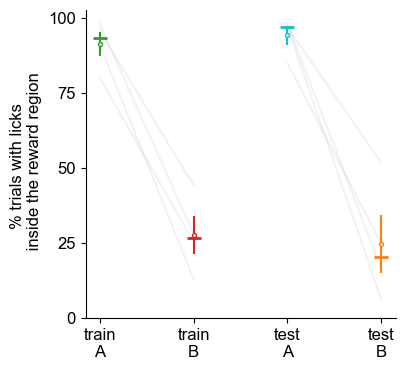

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
lick_averages(df, ax, stat_test=False)

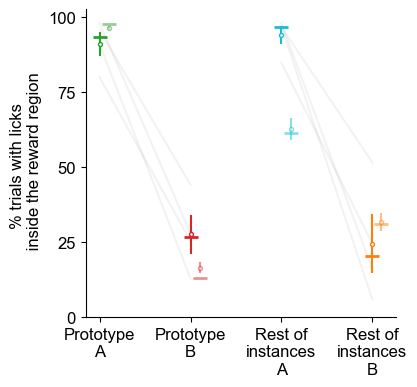

In [173]:
first100df = pd.read_csv(r"C:\Users\labadmin\Documents\GeneralizationPaper\Figure1\all_sessions_150_250_first100.csv", index_col=0) # one-shot exp
fig, ax = plt.subplots(1,1, figsize=(4,4))
lick_averages(df, ax, stat_test=False)
lick_averages(first100df, ax, lines=False, stat_test=False, alpha=0.5 , offset=0.1)
plt.savefig(r"..\results\onevscat.svg", dpi=300, bbox_inches='tight')

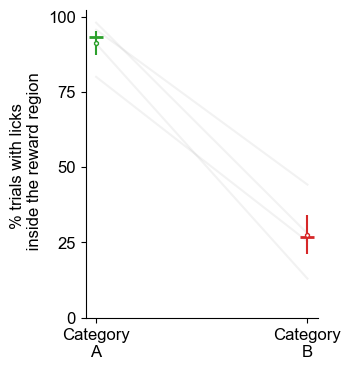

In [172]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
lick_averages_colapsed(df,ax, stat_test=False)

In [37]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_15', 'blk':'4'})
VG11.append({'mname': 'VG11', 'datexp': '2024_10_16', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_01', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_04', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_05', 'blk':'3'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_15', 'blk':'2'})

In [44]:
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_10_15', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_10_16', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_11_23', 'blk':'2'})


In [45]:
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_15', 'blk':'3'})
VG15.append({'mname': 'VG15', 'datexp': '2024_10_16', 'blk':'2'})
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
VG15.append({'mname': 'VG15', 'datexp': '2024_11_01', 'blk':'3'})

In [46]:
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_15', 'blk': '4'},
 {'mname': 'VG11', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_01', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_04', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_05', 'blk': '3'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_15', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_10_15', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_23', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_15', 'blk': '3'},
 {'mname': 'VG15', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_11_01', 'blk': '3'}]

In [47]:
from pathlib import Path

In [139]:
all_sessions = VG11 + VG14 + VG15
cod_dirs = np.empty((16,))
for sess in range(len(all_sessions)):
    name = all_sessions[sess]['mname']
    date = all_sessions[sess]['datexp']
    blk = all_sessions[sess]['blk']
    pth = Path(f"..\data\{name}\{date}\{blk}\cod_dirs.npy")
    cd = np.expand_dims(np.load(pth), axis=0)
    #stack cds
    if sess == 0:
        cod_dirs = cd
    else:
        cod_dirs = np.vstack((cod_dirs, cd))

In [143]:
cod_dirs.shape

(16, 2, 4, 4, 400)

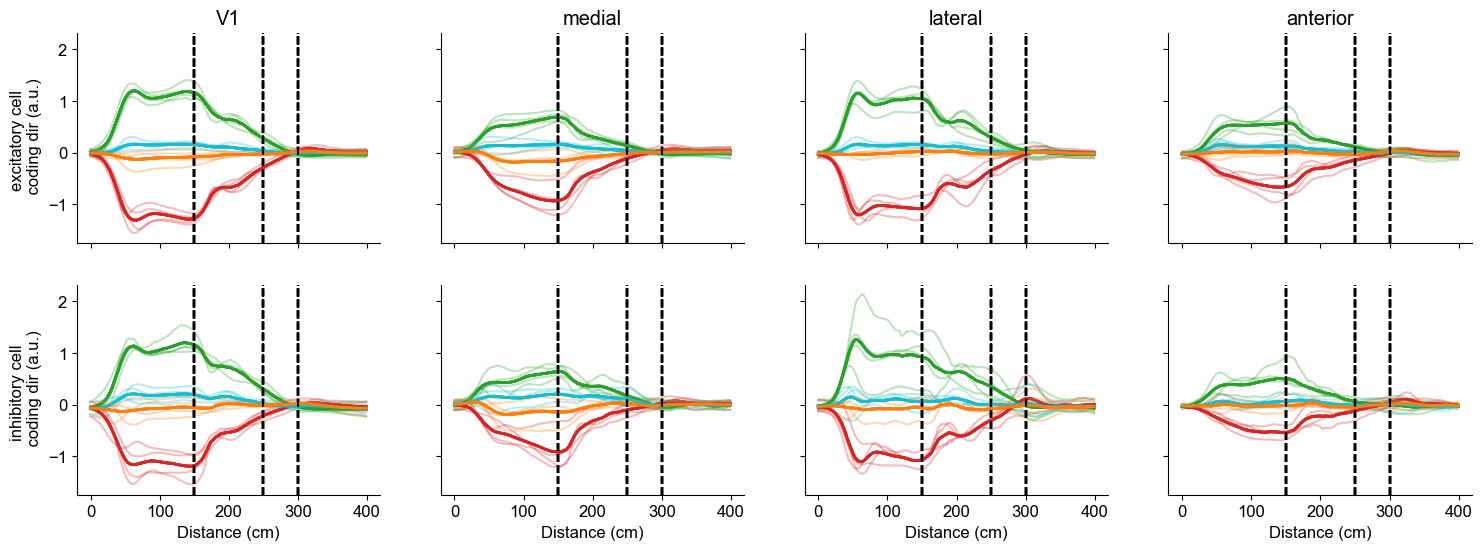

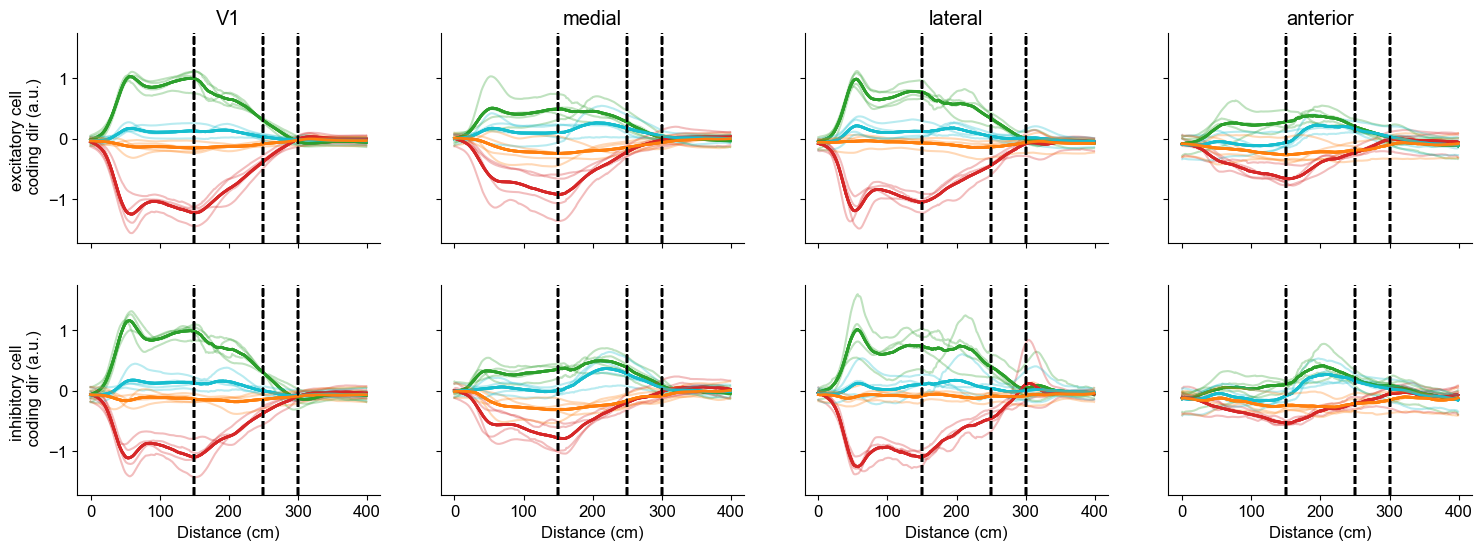

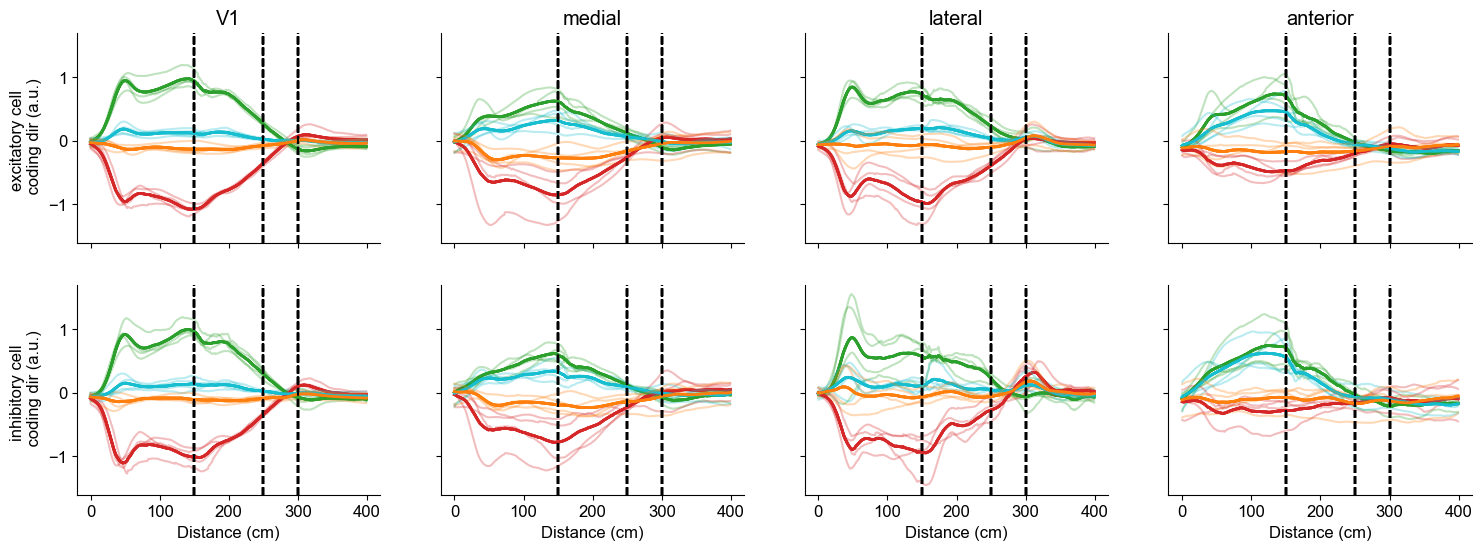

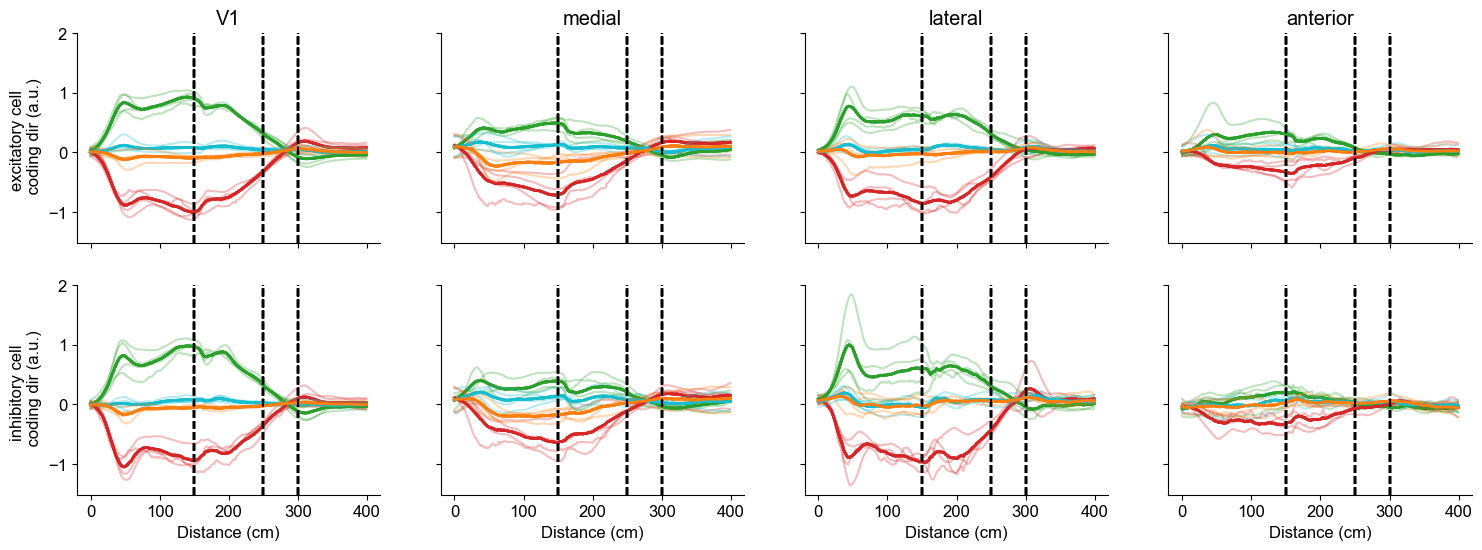

In [140]:
first_day = np.arange(0,16,4)
second_day = np.arange(1,16,4)
third_day = np.arange(2,16,4)
fourth_day = np.arange(3,16,4)
sess_days = [first_day, second_day, third_day, fourth_day]
areas = ['V1', 'medial', 'lateral', 'anterior']
day_titles = ['all rewarded before training', 'first training day', 'last training day', 'all rewarded after training']
for sess in sess_days:
    fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
    day_cds = cod_dirs[sess]
    avg_day = day_cds.mean(0)
    for days in range(4):
        for cell_type in range(2):
            for area in range(4):
                for trial_type in range(4):
                    ax[cell_type, area].plot(np.arange(0,400),day_cds[days, cell_type, area, trial_type, :], alpha=0.3, color=trial_type_palette[trial_type])   
                    ax[cell_type, area].plot(np.arange(0,400),avg_day[cell_type, area, trial_type, :], color=trial_type_palette[trial_type], linewidth=2)
                    ax[cell_type, area].axvline(x=150, color='k', linestyle='--')
                    ax[cell_type, area].axvline(x=250, color='k', linestyle='--')
                    ax[cell_type, area].axvline(x=300, color='k', linestyle='--')
                    if cell_type == 0:
                        ax[cell_type, area].set_xlabel('')
                        ax[cell_type, area].set_title(f"{areas[area]}", loc='center')
                    else:
                        ax[cell_type, area].set_xlabel('Distance (cm)')
                # if area != 0 do not plot the yticks
                if area == 0:
                    if cell_type == 0:
                        ax[cell_type, area].set_ylabel('excitatory cell \n coding dir (a.u.)')
                    else:
                        ax[cell_type, area].set_ylabel('inhibitory cell \n coding dir (a.u.)')

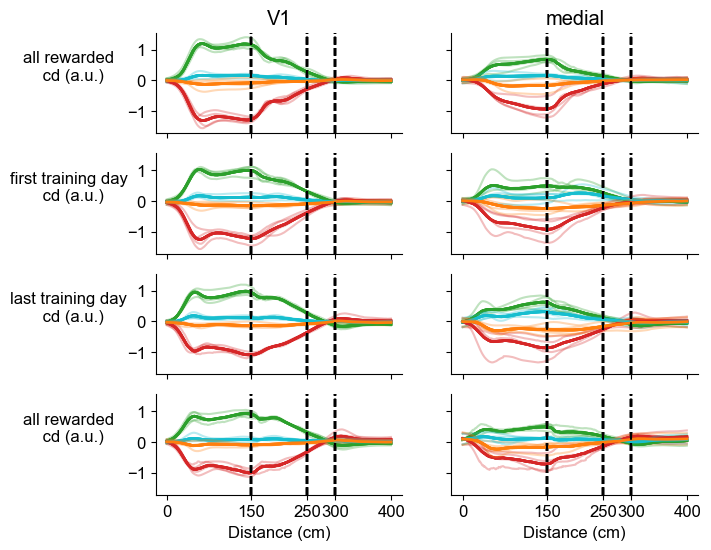

In [150]:
first_day = np.arange(0,16,4)
second_day = np.arange(1,16,4)
third_day = np.arange(2,16,4)
fourth_day = np.arange(3,16,4)
sess_days = [first_day, second_day, third_day, fourth_day]
areas = ['V1', 'medial', 'lateral', 'anterior']
day_titles = ['all rewarded', 'first training day', 'last training day', 'all rewarded']
fig, ax = plt.subplots(4,2, figsize=(7,6), sharey=True, sharex=True)
for i_s, sess in enumerate(sess_days):
    day_cds = cod_dirs[sess]
    avg_day = day_cds.mean(0)
    avg_day = avg_day[0,:,:,:]
    for days in range(4):
        ax[i_s,0].set_ylabel(f'{day_titles[i_s]} \n cd (a.u.)', rotation=0, labelpad=40)
        for area in range(2):
            ax[0,area].set_title(f"{areas[area]}", loc='center')
            ax[-1,area].set_xlabel('Distance (cm)')
            for trial_type in range(4):
                ax[i_s,area].plot(np.arange(0,400), avg_day[area, trial_type, :], color=trial_type_palette[trial_type], linewidth=2)
                ax[i_s,area].plot(np.arange(0,400), day_cds[days, 0, area, trial_type, :], alpha=0.3, color=trial_type_palette[trial_type])   
                ax[i_s,area].axvline(x=150, color='k', linestyle='--')
                ax[i_s,area].axvline(x=250, color='k', linestyle='--')
                ax[i_s,area].axvline(x=300, color='k', linestyle='--')
    ax[0,area].set_xticks([0, 150, 250, 300, 400])
                

In [104]:
rew_gis = np.empty((16,2,4))
nrew_gis = np.empty((16,2,4))
for day in range(cod_dirs.shape[0]):
    cd_selection = cod_dirs[day,:,:,:,25:275]
    cd_selection = cd_selection.mean(-1)
    for cell_type in range(2):
        for area in range(4):
            red_cyan = np.abs(cd_selection[cell_type, area, 1] - cd_selection[cell_type, area, 2])
            green_cyan = np.abs(cd_selection[cell_type, area, 0] - cd_selection[cell_type, area, 2])
            red_orange = np.abs(cd_selection[cell_type, area, 1] - cd_selection[cell_type, area, 3])
            green_orange = np.abs(cd_selection[cell_type, area, 0] - cd_selection[cell_type, area, 3])
            green_red  = np.abs(cd_selection[cell_type, area, 0] - cd_selection[cell_type, area, 1])
            rew_gis[day, cell_type, area] = (red_cyan - green_cyan) / green_red
            nrew_gis[day, cell_type, area] = (red_orange - green_orange) / green_red


In [106]:
from scipy.stats import sem 

In [108]:
rew_gran_overall = np.empty((4,2,4))
nrew_gran_overall = np.empty((4,2,4))
rew_ses = np.empty((4,2,4))
nrew_ses = np.empty((4,2,4))
for i_sess, sess in enumerate(sess_days):
    rew_gis_sess = rew_gis[sess]
    nrew_gis_sess = nrew_gis[sess]
    for cell_type in range(2):
        for area in range(4):
            rew_gran_overall[i_sess, cell_type, area] = np.mean(rew_gis_sess[:,cell_type, area], axis=0)
            nrew_gran_overall[i_sess, cell_type, area] = np.mean(nrew_gis_sess[:,cell_type, area],axis=0)
            rew_ses[i_sess, cell_type, area] = sem(rew_gis_sess[:,cell_type, area],axis=0)
            nrew_ses[i_sess, cell_type, area] = sem(nrew_gis_sess[:,cell_type, area],axis=0)

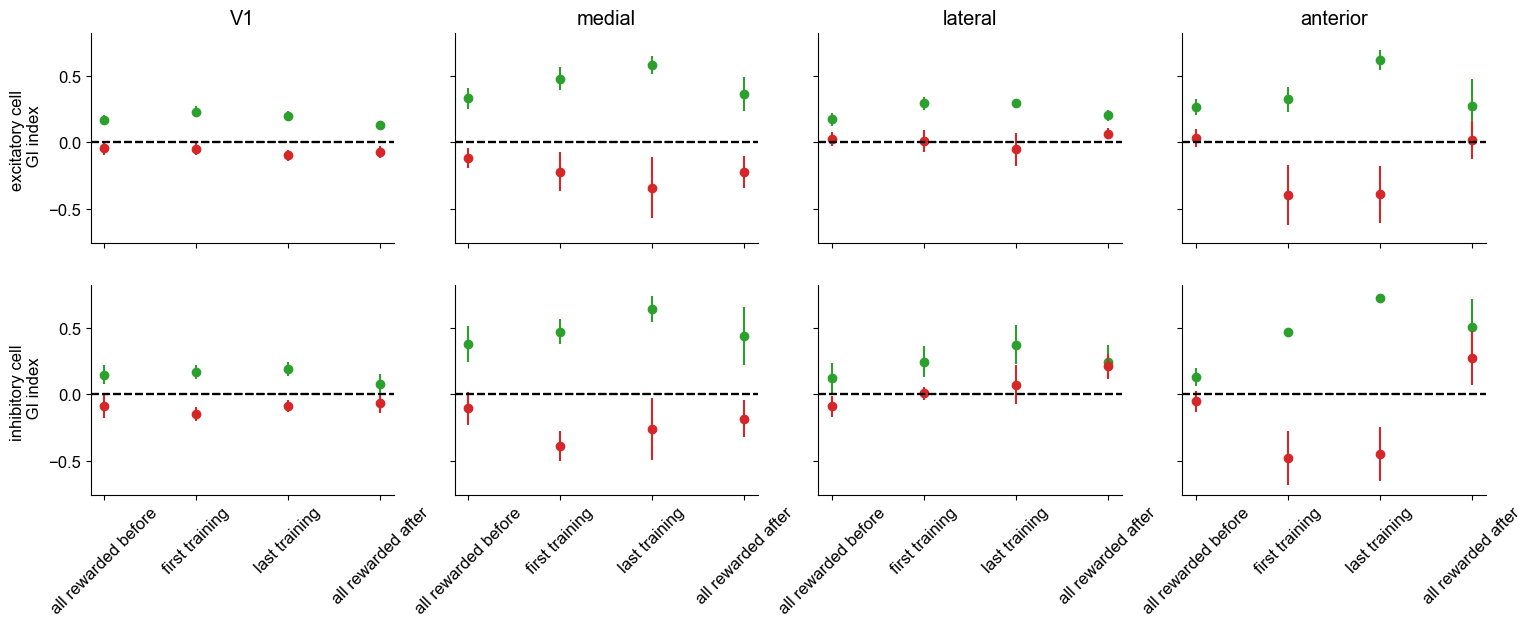

In [120]:
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
for day in range(4):
    for cell_type in range(2):
        for area in range(4):
            ax[cell_type,area].scatter(day, rew_gran_overall[day,cell_type,area], color='tab:green')
            ax[cell_type,area].errorbar(day, rew_gran_overall[day,cell_type,area], rew_ses[day, cell_type, area], color='tab:green')
            ax[cell_type,area].scatter(day, nrew_gran_overall[day,cell_type,area], color='tab:red')
            ax[cell_type,area].errorbar(day, nrew_gran_overall[day,cell_type,area], nrew_ses[day, cell_type, area], color='tab:red')
            ax[cell_type,area].set_xlabel('')
            if cell_type == 0:
                ax[cell_type,area].set_xlabel('')
                ax[cell_type,area].set_title(f"{areas[area]}", loc='center')
            else:
                ax[cell_type,area].set_xticks([0,1,2,3], ['all rewarded before', 'first training', 'last training', 'all rewarded after'], rotation=45)
            if area == 0:
                if cell_type == 0:
                    ax[cell_type,area].set_ylabel('excitatory cell \n GI index')
                else:
                    ax[cell_type,area].set_ylabel('inhibitory cell \n GI index')
            ax[cell_type,area].axhline(y=0, color='k', linestyle='--')

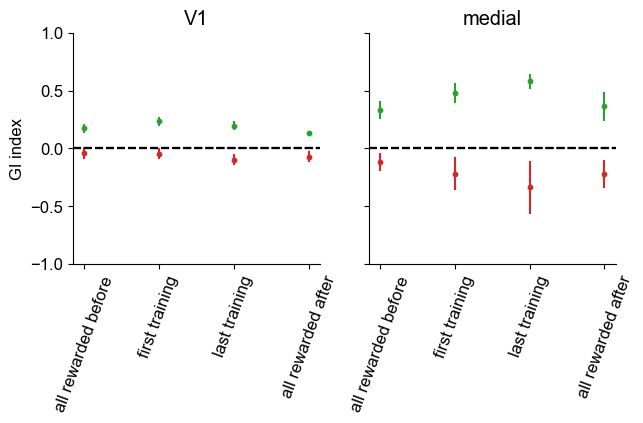

In [158]:
fig, ax = plt.subplots(1,2, figsize=(7,3), sharey=True, sharex=True)
cell_type = 0
for day in range(4):
    for area in range(2):
        ax[area].scatter(day, rew_gran_overall[day,cell_type,area], color='tab:green', s=10)
        ax[area].errorbar(day, rew_gran_overall[day,cell_type,area], rew_ses[day, cell_type, area], color='tab:green')
        ax[area].scatter(day, nrew_gran_overall[day,cell_type,area], color='tab:red', s=10)
        ax[area].errorbar(day, nrew_gran_overall[day,cell_type,area], nrew_ses[day, cell_type, area], color='tab:red')
        ax[area].set_xlabel('')
        ax[area].set_xticks([0,1,2,3], ['all rewarded before', 'first training', 'last training', 'all rewarded after'], rotation=70)
        ax[area].axhline(y=0, color='k', linestyle='--')
        ax[area].set_title(f"{areas[area]}", loc='center')
        ax[area].set_ylim(-1,1)
        if area == 0:
            ax[area].set_xlabel('')
            ax[area].set_ylabel('GI index')


In [207]:
istim_df = pd.DataFrame(m._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(1, len(istim_df)+1).astype(float)
istim_df

,istim,trial_no
0,2.0,1.0
1,1.0,2.0
2,1.0,3.0
3,3.0,4.0
4,1.0,5.0
...,...,...
395,1.0,396.0
396,51.0,397.0
397,1.0,398.0
398,39.0,399.0


In [179]:
from pathlib import Path
from src import redcells
for sess in all_sessions:
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True)
    frameselector = utils.get_frameselector(m)
    istim_df = pd.DataFrame(m._timeline['istim'], columns=['istim'])
    istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
    m.frameselector = (frameselector.reset_index()
        .rename(columns = {'index':'frame'})
        .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
        .set_index('frame'))
    green_channel = Path(rf"Z:\data\PROC\{name}\{date}\{blk}\suite2p")
    m.isred = redcells.get_redcells(green_channel)
    m.isred = m.isred[m._snr>=.25]
    m._spks = m._spks[m._snr>=.25]
    m._xpos = m._xpos[m._snr>=.25]
    m._ypos = m._ypos[m._snr>=.25]
    m._iplane = m._iplane[m._snr>=.25]
    m.iarea = m.iarea[m._snr>=.25]
    m.iregion = m.iregion[m._snr>=.25]
    m.xy_t = m.xy_t[m._snr>=.25]
    m.interp_spks = utils.interp_spks_by_corridorlength(m, m.frameselector, z = True, corridor_length=400)
    m.trial_dict = utils.get_trialno_bytype(m.frameselector)
    utils.compute_dprime(m, discrimination_region = (25,275), corridor_length = 400, nogray = False)
    utils.save_mouse(m, compressed=False, mdl_path="D:\mouseobj") #save mouse obj for later use

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_15\4
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_15_4.mat not found, trying with fname: VG11_2024_10_15_4.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:49<00:00, 17.49s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_15_4_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(28508, 2)
39 11681
interpolating 25932 neurons, 11643 frames to
the vector of distance with shape: (11643,)
neurons: 25932, trials: 345, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_10_15\4
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_16\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_16_2.mat not found, trying with fname: VG11_2024_10_16_2.mat 
Timeline file is 

100%|██████████| 20/20 [06:25<00:00, 19.27s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_16_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(32174, 2)
37 10871
interpolating 29324 neurons, 10835 frames to
the vector of distance with shape: (10835,)
neurons: 29324, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_10_16\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_31_2.mat not found, trying with fname: VG11_2024_10_31_2.mat 
Timeline file is 

100%|██████████| 20/20 [06:27<00:00, 19.36s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_31_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(30674, 2)
39 13396
interpolating 29842 neurons, 13358 frames to
the vector of distance with shape: (13358,)
neurons: 29842, trials: 254, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_10_31\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_01\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_01_2.mat not found, trying with fname: VG11_2024_11_01_2.mat 
Timeline file is 

100%|██████████| 20/20 [04:20<00:00, 13.02s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_11_01_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(21049, 2)
40 10402
interpolating 19578 neurons, 10363 frames to
the vector of distance with shape: (10363,)
neurons: 19578, trials: 351, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_11_01\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_04\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_04_2.mat not found, trying with fname: VG11_2024_11_04_2.mat 
Timeline file is 

100%|██████████| 20/20 [05:19<00:00, 16.00s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_11_04_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(25262, 2)
40 13380
interpolating 23124 neurons, 13341 frames to
the vector of distance with shape: (13341,)
neurons: 23124, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_11_04\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_05\3
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_05_3.mat not found, trying with fname: VG11_2024_11_05_3.mat 
Timeline file is 

100%|██████████| 20/20 [05:32<00:00, 16.62s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_11_05_3_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(26370, 2)
39 11913
interpolating 24045 neurons, 11875 frames to
the vector of distance with shape: (11875,)
neurons: 24045, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_11_05\3
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_14\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_14_2.mat not found, trying with fname: VG11_2024_11_14_2.mat 
Timeline file is 

100%|██████████| 20/20 [05:00<00:00, 15.01s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_11_14_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(24767, 2)
39 11190
interpolating 22558 neurons, 11152 frames to
the vector of distance with shape: (11152,)
neurons: 22558, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_11_14\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_15\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_15_2.mat not found, trying with fname: VG11_2024_11_15_2.mat 
Timeline file is 

100%|██████████| 20/20 [05:32<00:00, 16.63s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_11_15_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(26771, 2)
39 12821
interpolating 24964 neurons, 12783 frames to
the vector of distance with shape: (12783,)
neurons: 24964, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG11\2024_11_15\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_10_15\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_10_15_2.mat not found, trying with fname: VG14_2024_10_15_2.mat 
Timeline file is 

100%|██████████| 20/20 [06:30<00:00, 19.53s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_10_15_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(32348, 2)
37 11281
interpolating 27048 neurons, 11245 frames to
the vector of distance with shape: (11245,)
neurons: 27048, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG14\2024_10_15\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_10_16\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_10_16_2.mat not found, trying with fname: VG14_2024_10_16_2.mat 
Timeline file is 

100%|██████████| 20/20 [07:32<00:00, 22.65s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_10_16_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(35951, 2)
40 13457
interpolating 31829 neurons, 13418 frames to
the vector of distance with shape: (13418,)
neurons: 31829, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG14\2024_10_16\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_11_21\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_11_21_2.mat not found, trying with fname: VG14_2024_11_21_2.mat 
Timeline file is 

100%|██████████| 20/20 [07:00<00:00, 21.01s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_11_21_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(34859, 2)
41 11762
interpolating 29439 neurons, 11722 frames to
the vector of distance with shape: (11722,)
neurons: 29439, trials: 371, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG14\2024_11_21\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_11_23\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_11_23_2.mat not found, trying with fname: VG14_2024_11_23_2.mat 
Timeline file is 

100%|██████████| 20/20 [06:15<00:00, 18.78s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_11_23_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(30553, 2)
38 12461
interpolating 26262 neurons, 12423 frames to
the vector of distance with shape: (12423,)
neurons: 26262, trials: 187, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG14\2024_11_23\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_15\3
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_15_3.mat not found, trying with fname: VG15_2024_10_15_3.mat 
Timeline file is 

100%|██████████| 20/20 [07:52<00:00, 23.60s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG15_2024_10_15_3_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(40920, 2)
38 10170
interpolating 35094 neurons, 10133 frames to
the vector of distance with shape: (10133,)
neurons: 35094, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG15\2024_10_15\3
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_16\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_16_2.mat not found, trying with fname: VG15_2024_10_16_2.mat 
Timeline file is 

100%|██████████| 20/20 [06:48<00:00, 20.45s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG15_2024_10_16_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(35226, 2)
37 9906
interpolating 30110 neurons, 9870 frames to
the vector of distance with shape: (9870,)
neurons: 30110, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG15\2024_10_16\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_31_2.mat not found, trying with fname: VG15_2024_10_31_2.mat 
Timeline file is in 

100%|██████████| 20/20 [05:25<00:00, 16.29s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG15_2024_10_31_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(25717, 2)
40 13246
interpolating 22309 neurons, 13207 frames to
the vector of distance with shape: (13207,)
neurons: 22309, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG15\2024_10_31\2
Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_11_01\3
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_11_01_3.mat not found, trying with fname: VG15_2024_11_01_3.mat 
Timeline file is 

100%|██████████| 20/20 [05:07<00:00, 15.38s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG15_2024_11_01_3_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
(23298, 2)
39 14749
interpolating 20669 neurons, 14711 frames to
the vector of distance with shape: (14711,)
neurons: 20669, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG15\2024_11_01\3


In [208]:
frameselector = utils.get_frameselector(m)
istim_df = pd.DataFrame(m._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(1, len(istim_df)+1).astype(float)
m.frameselector = (frameselector.reset_index()
    .rename(columns = {'index':'frame'})
    .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
    .set_index('frame'))

In [209]:
colapsed = m.frameselector.assign(rewarded = m.frameselector["trial_type"].map({"rewarded": "rewarded", "non rewarded": "non rewarded", "rewarded test": "rewarded", "non rewarded test": "non rewarded"}))

In [ ]:
category = ['rewarded', 'non rewarded']
nneurons = m.interp_spks.shape[0]
id_responses = np.empty((nneurons, 2, 51, 400))
for ic, cat in enumerate(category):
    for idx in np.arange(1,52):
        a = colapsed.query(f"istim=={idx} & rewarded == '{cat}'")
        ix = idx - 1
        trials = a.trial_no.unique().astype(int) -1
        reps = len(a.trial_no.unique())
        if reps >= 2:
            avg = m.interp_spks[:,trials,:].mean(1)
            id_responses[:, ic, ix,:] = avg
        else:
            resp = m.interp_spks[:,trials,:]
            id_responses[:, ic, ix,:] = resp.squeeze()
id_responses.shape

(20669, 2, 51, 400)

In [361]:
id_resp_idx = id_responses.reshape(nneurons, 102, 400)

<AxesSubplot:>

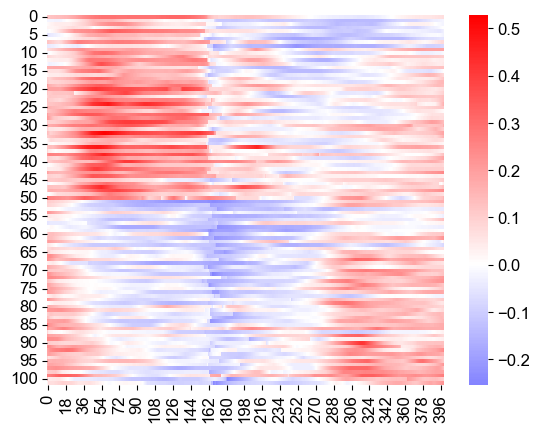

In [509]:
ia = utils.get_region_idx(m.iarea, "medial")
dp = m.train_dp > np.percentile(m.train_dp[ia], 95)
selection = ia * dp
n = id_resp_idx[selection, :,:].mean(0)
sns.heatmap(n, cmap='bwr', center=0)

In [507]:
from itertools import combinations
representation_matrix = np.ones((102,102)) * np.nan
pairs = list(combinations(np.arange(102),2))
id_area = id_resp_idx[selection, :,:].mean(0)
for pair in pairs:
    instance_a = id_area[pair[0],:]
    instance_b = id_area[pair[1],:]
    corr = np.corrcoef(instance_a, instance_b)[0,1]
    representation_matrix[pair[0],pair[1]] = corr
    representation_matrix[pair[1],pair[0]] = corr

Text(65, -2, 'Category B')

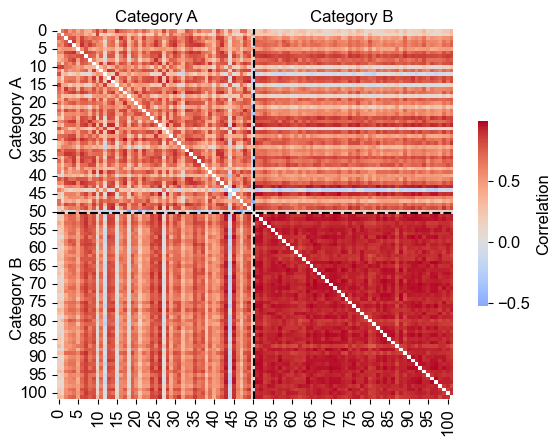

In [508]:
sns.heatmap(representation_matrix, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation', 'shrink': 0.5})
plt.axvline(50.7, color='k', linestyle='--')
plt.axhline(50.7, color='k', linestyle='--')
plt.text(-12, 35, 'Category A', fontsize=12, rotation=90)
plt.text(-12, 85, 'Category B', fontsize=12, rotation=90)
plt.text(15, -2, 'Category A', fontsize=12)
plt.text(65, -2, 'Category B', fontsize=12)

,trial_no,trial_type,contrast,speed,distance,reward_delivery,intertrial,time_fromstart,time_within_trial,istim
frame,,,,,,,,,,
39,1.0,non rewarded test,0.007021,4.130294,1.053219,NaN,False,0.115630,0.000000,1.0
40,1.0,non rewarded test,0.106766,4.783726,16.014969,NaN,False,0.388722,0.273092,1.0
41,1.0,non rewarded test,0.234079,5.605243,35.111775,NaN,False,0.725313,0.609683,1.0
42,1.0,non rewarded test,0.355822,2.133019,53.373270,NaN,False,1.043919,0.928289,1.0
43,1.0,non rewarded test,0.430667,0.587606,64.600000,NaN,False,1.331385,1.215755,1.0
...,...,...,...,...,...,...,...,...,...,...
14652,397.0,rewarded test,0.000000,0.752362,356.250000,NaN,True,4605.860896,17.608133,1.0
14653,397.0,rewarded test,0.000000,0.620704,366.700000,NaN,True,4606.192045,17.939282,1.0
14654,397.0,rewarded test,0.000000,1.854626,380.093662,NaN,True,4606.496971,18.244208,1.0
